In [4]:
import psycopg2
import psycopg2.extras

class Db(object):
    _connection = None
    
    def __init__(self, host="localhost", user="user", password="1", db="db"):
        try:
            self._connection = psycopg2.connect("host='{0}' user='{1}' password='{2}' dbname='{3}'".format(
                    host, user, password, db))
        except psycopg2.Error as err:
            print("Connection error: {}".format(err))
            self._connection.close()
    
    def query(self, sql, params=None, cursor='list'):
        if not self._connection:
            return False
        
        data = False
        
        if cursor == 'dict':
            # Assoc cursor
            factory = psycopg2.extras.DictCursor
        else:
            # Standard cursor
            factory = psycopg2.extensions.cursor
        try:
            cur = self._connection.cursor(cursor_factory=factory) # by column name
            cur.execute(sql, params)
            data = cur.fetchall()
        except psycopg2.Error as err:
            print("Query error: {}".format(err))
            
        return data

db = Db(host="localhost", user="developer", password="1", db="go_finance")

In [8]:
from sklearn.cluster import MeanShift, estimate_bandwidth
import operator
import matplotlib.pyplot as plt
import numpy as np
import talib
from datetime import date, timedelta
table = 'prices'
order_dt = 'ASC'

def prices(symbols, dt_from = date.today(), period = 90):
    """
    Get prices from database for one or multiple symbols.
    """
    dt_to = dt_from - timedelta(days=period)
    cond = {
        'symbols': symbols,
        'to': dt_from,
        'from': dt_to
    }

    # FIXME Change to view
    sql = """
        SELECT
            symbol,
            dt,
            ROUND(CASE WHEN adj IS NOT NULL AND close > 0
                THEN adj / close::real ELSE 1 END * open) / {0} as open,
            ROUND(CASE WHEN adj IS NOT NULL AND close > 0
                THEN adj / close::real ELSE 1 END * high) / {0} as high,
            ROUND(CASE WHEN adj IS NOT NULL AND close > 0
                THEN adj / close::real ELSE 1 END * low) / {0} as low,
            CASE WHEN adj IS NOT NULL THEN adj ELSE close
                END::real / {0} as close,
            volume::int
        FROM {1}
        WHERE symbol IN (SELECT unnest(%(symbols)s)) AND dt BETWEEN %(from)s AND %(to)s
        ORDER BY dt {2}""".format(10000, table, order_dt)

    return db.query(sql, cond)


In [9]:
# get price history from local db
def from_db(symbol):
    spy = prices([symbol], date.today(), 1000)
    return np.array([[x[1]] for x in spy]), np.array([[x[3], x[4], x[5]] for x in spy])

In [10]:
# get price history from Yahoo! Finance with Pandas
def from_yahoo(symbol):
    import pandas as pd
    import pandas_datareader.data as web

    start = date(2010,1,1)
    end = date.today()
    prices_df = web.DataReader(symbol, "yahoo", start, end)

    return prices_df.index, prices_df.as_matrix(columns=['Adj Close'])

In [15]:
symbol = "DIA"
#Adjust Calculation Set ; data2 size
dates, data = from_db(symbol)
data2 = data[:]

# Определение связных областей
# http://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html
# http://scikit-learn.org/stable/auto_examples/cluster/plot_mean_shift.html#sphx-glr-auto-examples-cluster-plot-mean-shift-py
# https://en.wikipedia.org/wiki/Mean_shift
# Images
# http://wiki.technicalvision.ru/index.php/%D0%92%D1%8B%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5_%D0%B8_%D0%BE%D0%BF%D0%B8%D1%81%D0%B0%D0%BD%D0%B8%D0%B5_%D0%BE%D0%B1%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D0%B9
# http://cyberleninka.ru/article/n/algoritm-vydeleniya-svyaznyh-oblastey-pri-raspoznavanii-obektov

# Data = All Data ; Data2 = Adjusted DataSet
bandwidth = estimate_bandwidth(data2, quantile=0.1, n_samples=50)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, n_jobs=3)

# fit the data
ms.fit(data2)

MeanShift(bandwidth=2.9137672725146602, bin_seeding=True, cluster_all=True,
     min_bin_freq=1, n_jobs=3, seeds=None)

In [16]:
#Calculate Support/Resistance
ml_results = []
for k in range(len(np.unique(ms.labels_))):
    my_members = ms.labels_ == k
    values = data[my_members, 0]    
    #print(values)

    # find the edges
    ml_results.append(min(values))
    ml_results.append(max(values))
sorted(ml_results)

[151.63560000000001,
 151.91759999999999,
 158.72550000000001,
 158.98830000000001,
 159.13800000000001,
 167.3322,
 168.2749,
 178.09039999999999,
 178.62209999999999,
 186.02379999999999,
 188.09780000000001,
 190.25,
 190.59,
 192.78,
 195.69,
 195.69]

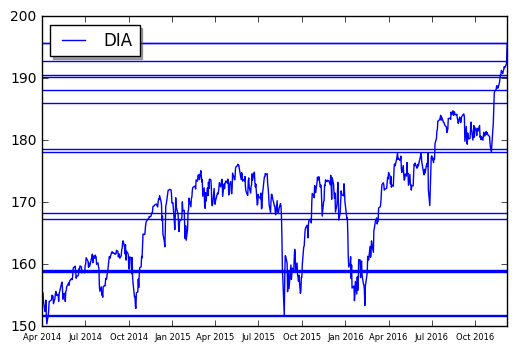

In [17]:
#Plot Security
plt.plot(dates, data[:,2], label = symbol)

#Plot Support/Resistance
for k in ml_results:
    plt.axhline(y=k)

#Change font size of x-axis    
plt.tick_params(axis='x', which='major', labelsize=6)
plt.legend(loc = 'upper left', shadow = True)
plt.show()